In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import utils, archimedean, extreme
import importlib

import time
import pickle

%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "font.size":22})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size":22})

In [2]:
# load data
print("#1 load data")

path = './data/synthetic/CNSD_C_1_14.p'
U0 = utils.load_data_0(path).float();
nsamples = 240 # monthly maxima
U0 = U0*nsamples/(nsamples+1)

n_r = 100
n_z = 100
ndims = 3

labels = ["Belle-Ile", "Groix", "Lorient"]

#1 load data


In [3]:
# compute empirical Kendall
print("#2 compute empirical Kendall")

data = U0.detach().clone()

with torch.no_grad():
    zs = data[:,[0]].numel()
    c = torch.zeros(zs)
    for j in range(zs):
        c[j] = torch.sum(torch.prod(data<data[j,:],axis=1).double())/(zs+1)

W = np.sort(c.detach().numpy())
K = np.sum(W.reshape(1,-1)<=W.reshape(-1,1),axis=1)/zs
W0 = np.array(W)
K0 = np.array(K)

indices = np.where(np.diff(np.hstack([-1,W]))!=0)[0].astype(int)
W = W[indices]
K = K[indices]

K_eq = np.linspace(1/(n_r*n_z),1,(n_r*n_z))
K_idx_l = np.sum(np.where(K_eq.reshape(-1,1) > K.reshape(1,-1),1,0),axis=1)-1
K_idx_u = len(W)-np.sum(np.where(K_eq.reshape(-1,1) < K[::-1].reshape(1,-1),1,0),axis=1)
K_idx = ((K_idx_u-K_idx_l)>=1)*(K_idx_u!=len(W))*(K_idx_l!=-1)

W_eq = np.zeros_like(K_eq)
W_eq[K_idx_u==len(W)] = W[-1]
W_eq[K_idx] = (K_eq[K_idx]-K[K_idx_l[K_idx]])/(K[K_idx_u[K_idx]]-K[K_idx_l[K_idx]])*(W[K_idx_u[K_idx]]-W[K_idx_l[K_idx]])+W[K_idx_l[K_idx]]

K = K_eq
W = W_eq

rp = np.hstack([K[0],np.diff(K)]) #reverse p
p = rp[::-1]
w = np.array(W)
w = torch.tensor(w[::-1].copy())

#2 compute empirical Kendall


In [4]:
# load stdf
print("#3 load stdf")

ckpt = torch.load('./checkpoints/ckpt_EE_1exp_i%d.ckpt'%(5000))
stdf_GNN = extreme.stdfStochastic(ndims=ndims)
stdf_GNN.load_state_dict(ckpt['model_state_dict'])
stdf_GNN.resample_M(10000)

#3 load stdf


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [5]:
# sample Z
print("#4 sample Z")

W = stdf_GNN.sample_M(200*(ndims-1)*100)
U = -torch.rand(200*(ndims-1)*100,1)/W
U2 = -(U.reshape(ndims-1,-1,ndims).max(dim=0)[0])
idx_u = stdf_GNN(U2)<=1
S = U2[idx_u,:]

# fix marginals
S = S.detach().numpy()
for i in range(ndims):
    S[:, i] = scipy.stats.rankdata(S[:, i], 'ordinal')/(len(S)+1)
S = 1-(1-S)**(1/(ndims-1))
S = torch.tensor(S)

Z = stdf_GNN(S).detach()

#4 sample Z


In [6]:
phiStochastic = archimedean.PhiDMStochastic(ndims)
opt_phi = torch.optim.Adam(phiStochastic.parameters(),lr=1e-3)

n_iter = 5100
kloss_array = np.zeros(n_iter)
eloss_array = np.zeros(n_iter)
time_array = np.zeros(n_iter)
iter_array = np.zeros(n_iter)
time_taken = 0

for n_iter in range(5100):
    
    # resample Z at every iteration closer to convergence
    if n_iter<1000 and n_iter%10 == 0:
        z = Z[np.random.randint(0,len(Z),n_z)]
    if n_iter>=1000 and n_iter<2000 and n_iter%5 == 0:
        z = Z[np.random.randint(0,len(Z),n_z)]
    if n_iter>=2000 and n_iter<3000 and n_iter%2 == 0:
        z = Z[np.random.randint(0,len(Z),n_z)]
    if n_iter>=3000:
        z = Z[np.random.randint(0,len(Z),n_z)]
        
    time_start = time.time()
    opt_phi.zero_grad()
    phiStochastic.resample_R(n_r)
    r = phiStochastic.sample_R(n_r)
    rz = (r.view(-1,1)*z.view(1,-1)).view(-1)
    rz = torch.sort(rz)[0]
    w_A = phiStochastic(rz)
    kloss = torch.sum((w-w_A)**2) 
    eloss = (r.mean()-1)**2
    reg_loss = kloss + eloss
    reg_loss.backward()
    opt_phi.step()
    time_end = time.time()
    time_taken += (time_end-time_start)
    
    kloss_array[n_iter] = kloss.item()
    eloss_array[n_iter] = eloss.item()
    time_array[n_iter] = time_taken
    iter_array[n_iter] = n_iter    

    if n_iter%100== 0:
        print(n_iter, time_taken, kloss.item(), eloss.item())
        
        torch.save({
            'n_iter': n_iter,
            'model_state_dict': phiStochastic.model.state_dict(),
            'optimizer_state_dict': opt_phi.state_dict(),
        }, './checkpoints/ckpt_EE_2R_i%d.ckpt'%(n_iter))
        


0 0.023885726928710938 185.44523549642884 0.0009714618208818138
100 1.5105628967285156 31.631101731729366 0.26520079374313354
200 2.986079692840576 13.071059669409237 0.6742205023765564
300 4.5000293254852295 9.294267351128486 0.42272859811782837
400 6.002865314483643 7.279639081345264 0.43817874789237976
500 7.54804539680481 18.808611122480848 0.22618651390075684
600 9.039237022399902 12.204649845995412 0.07213500142097473
700 10.572529554367065 8.88579896358845 0.1940210461616516
800 12.105674982070923 2.338655749737212 0.24581387639045715
900 13.642904043197632 6.3251559568696205 0.7219590544700623
1000 15.183763027191162 6.24812826202751 0.13690133392810822
1100 16.74038577079773 2.727296327001538 0.010825641453266144
1200 18.370641946792603 2.041525045492124 0.0017727975500747561
1300 19.99010157585144 1.8876919806468038 0.020946936681866646
1400 21.693174839019775 3.1703728658189965 0.0072543807327747345
1500 23.248597145080566 4.794990523712409 0.0007096609333530068
1600 24.8116

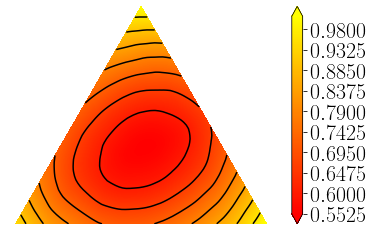

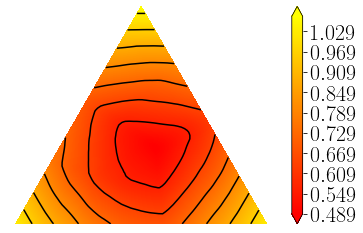

In [7]:
stdfCFG = extreme.stdfCFG(U0, phi=phiStochastic)
stdfPickands = extreme.stdfPickands(U0, phi=phiStochastic)

utils.plot_stdf3(stdfCFG)
utils.plot_stdf3(stdfPickands)

In [8]:
stdf = extreme.stdfNSD(alpha = torch.tensor([1.,2.,3.]), rho = torch.tensor([-0.69]))

In [9]:
U_test = utils.rand_simplex(10000,ndims)

stdfmax = stdfCFG(U_test)
stdfGT = stdf(U_test)
IRAEloss = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
print(IRAEloss)

0.030580434948205948


In [10]:
U_test = utils.rand_simplex(10000,ndims)

stdfmax = stdfPickands(U_test)
stdfGT = stdf(U_test)
IRAEloss = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
print(IRAEloss)

0.050018444657325745
